In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import warnings
from itertools import permutations

from mlxtend.preprocessing import TransactionEncoder

In [22]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

## Dataset

In [23]:
data_df = pd.read_csv('../../datasets/market_basket/market_basket.csv', header=None)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [25]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [26]:
class MostPopularItemsPlot:
    
    def __init__(self, item_count):
        
        self.item_count = item_count
        self.bins = np.linspace(0, 1, item_count)
        self.colors = plt.cm.rainbow(self.bins)
    
    def draw(self, data):
        frequencies = data.value_counts().head(self.item_count)
        frequencies.plot.bar(color=self.colors, figsize=(13, 5))

        plt.title('Frequency of the most popular items', fontsize=20)
        plt.xticks(rotation = 90)
        plt.grid()
        plt.show()
        
class TopChoicesPlot:
    
    def __init__(self, item_count, source_label):
        
        self.item_count = item_count
        self.source_label = source_label
        self.bins = np.linspace(0, item_count, 1)
        self.colors = plt.cm.Set1(self.bins)

        warnings.filterwarnings('ignore')
        
    def draw(self, df, target):
        
        df[self.source_label] = self.source_label
        df_truncated = data_df.truncate(before = -1, after = self.item_count)
        
        graph = nx.from_pandas_edgelist(df_truncated, source = self.source_label, target=target, edge_attr = True)
        
        plt.rcParams['figure.figsize'] = (13, 13)
        pos = nx.spring_layout(graph)

        nx.draw_networkx_nodes(graph, pos, node_size=12000, node_color = self.colors)
        nx.draw_networkx_edges(graph, pos, width = 3, alpha = 0.6, edge_color='black')
        nx.draw_networkx_labels(graph, pos, font_size=15, font_family='sans-serif')

        plt.axis('off')
        plt.grid()
        plt.title(f'Top {self.item_count} first choices', fontsize = 20)
        plt.show()
        
        return graph

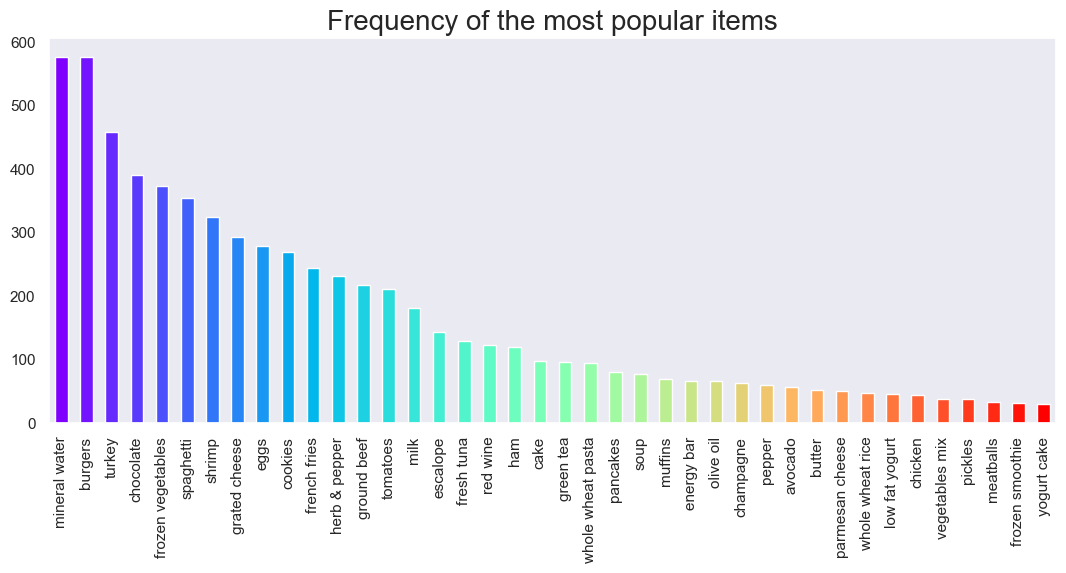

In [27]:
#Previewing most popular items frequencies for a specified column index
#Used for data analysis only. For example food items with bigger frequencies 
#should be correlated with more other items
preview_col = 0

mpi_plot = MostPopularItemsPlot(40)
mpi_plot.draw(data_df[preview_col])

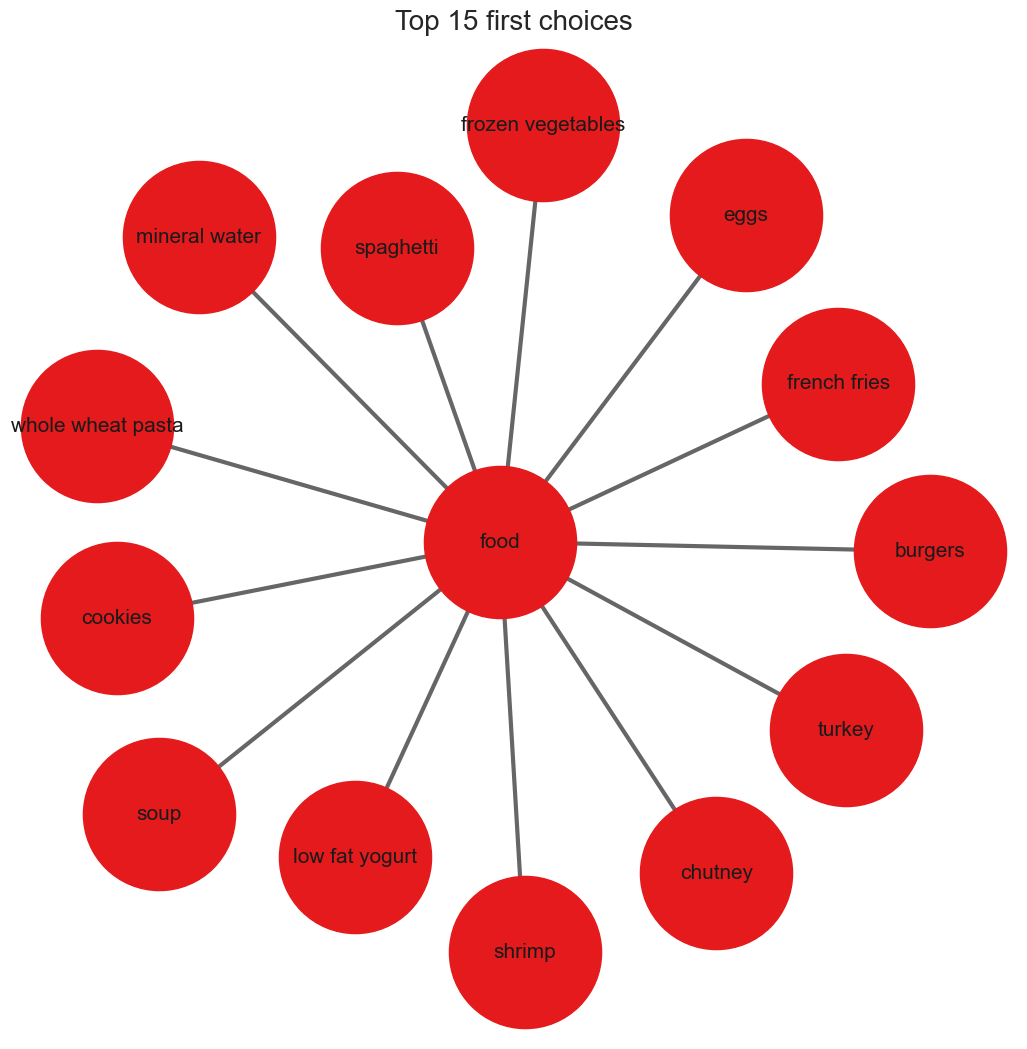

In [28]:
#Previewing top 15 choices for a specified column index
#Used for data analysis only. For example we can see how the number
#of food items descreses for the columns at a right table side
preview_col = 0

tc_plot = TopChoicesPlot(15, 'food')
graph = tc_plot.draw(data_df, preview_col)

## Getting the list of transactions

In [29]:
class RuleList(list):
    
    def __init__(self, items):
        
        super().__init__(self)
        self.extend(list(permutations(items, 2)))
     
    def describe(self):
        print('# of rules:',len(self))
        print(self[:5])
    
class Transaction(list):
    
    def __init__(self, values):
        super().__init__(self)
        self.extend(values)
    
    def from_df(df, row):
        columns_len = len(df.columns)
        values = [str(df.values[row, j]) for j in range(0, columns_len)]
        return Transaction(values)

class TransactionList(list):
    def __init__(self):
        super().__init__(self)
    
    def item_map(self):
        encoder = TransactionEncoder()
        encoder.fit(self)

        encoded_transactions = encoder.transform(self)

        encoded_df = pd.DataFrame(encoded_transactions, columns=encoder.columns_) 
        encoded_df.drop('nan', axis=1)
        return encoded_df
    
    def flatten(self):
        return [item for transaction in self for item in transaction]
    
    def get_items(self, is_unique):
        flattened = self.flatten()
        
        if is_unique:
            items = list(set(flattened))
            if 'nan' in items: 
                items.remove('nan')
            return items
        else:
            return flattened;
    
    def from_df(df):
        df_len = len(df)
        transactions = TransactionList()
        for i in range(0, df_len) :
            transactions.append(Transaction.from_df(df, i))
        
        return transactions

In [30]:
transactions = TransactionList.from_df(data_df)

In [31]:
items = transactions.get_items(is_unique=True)
len(items)

121

In [32]:
rules = RuleList(items)
rules.describe()

# of rules: 14520
[('cereals', 'candy bars'), ('cereals', 'soda'), ('cereals', 'escalope'), ('cereals', 'brownies'), ('cereals', 'gums')]


In [33]:
item_map_df = transactions.item_map()
item_map_df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,eggplant,...,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


## Metrics and prunning

In [34]:
class Metrics:
   
    def __init__(self):
        self.__support = None

    def item_support(self, item_map, item):
        return self.support(item_map).loc[item].values[0]
        
    def support(self, item_map):
        if not (self.__support is None):
            return self.__support
        
        support = item_map.mean()
        df = pd.DataFrame(support, columns=['support'])
        self.__support = df.sort_values('support', ascending=False)
        
        print('Support metric was cached successfully')
        
        return self.__support
    
    def paired_support(self, item_map, item1, item2):
        logical_and = np.logical_and(item_map[item1], item_map[item2])
        return logical_and.mean()
    
    def confidence(self, item_map, item1, item2):
        paired_support = self.paired_support(item_map, item1, item2)
        support = self.support(item_map).loc[item1].values[0]
        return paired_support / support
    
    def lift(self, item_map, item1, item2):
        paired_support = self.paired_support(item_map, item1, item2)
        support1 = self.support(item_map).loc[item1].values[0]
        support2 = self.support(item_map).loc[item2].values[0]
        return paired_support / (support1 * support2)
     
    def conviction(self, item_map, antecedent, consequent):
        #Compute support for antecedent AND consequent
        support_AC = self.paired_support(item_map, antecedent, consequent)
        
        #Compute support for antecedent
        support_A = self.support(item_map).loc[antecedent].values[0]
        
        #Compute support for NOT consequent
        support_nC = 1.0 - self.support(item_map).loc[consequent].values[0]
        
        #Compute support for antecedent AND NOT consequent 
        support_AnC = support_A - support_AC
        
        #Compute and return conviction
        return (support_A * support_nC) / support_AnC
    
    def leverage(self, item_map, antecedent, consequent):
        #Compute support for antecedent AND consequent
        support_AC = self.paired_support(item_map, antecedent, consequent)
        
        #Compute support for antecedent
        support_A = self.support(item_map).loc[antecedent].values[0]
        
        #Compute support for consequent
        support_C = self.support(item_map).loc[consequent].values[0]
        
        #Return leverage
        return support_AC - support_A * support_C
    
    def zhang(self, item_map, antecedent, consequent):
        #Compute support for antecedent
        support_A = self.support(item_map).loc[antecedent].values[0]
    
        #Compute support for consequent
        support_C = self.support(item_map).loc[consequent].values[0]
        
        #Compute support for antecedent AND consequent
        support_AC = self.paired_support(item_map, antecedent, consequent)
        
        #Compute the expressions for the numerator and denominator
        numerator = support_AC - support_A * support_C
        denominator = max(support_AC * (1 - support_A), support_A * (support_C - support_AC))
        
        # Return Zhang's metric
        return numerator / denominator

In [35]:
metrics = Metrics()

support_df = metrics.support(item_map_df)
support_df.head()

Support metric was cached successfully


,support
food,1.000000
nan,0.999867
mineral water,0.238368
eggs,0.179709
spaghetti,0.174110


In [36]:
#Support for a pair calculation example
supportBF = metrics.paired_support(item_map_df, 'burgers', 'french fries')
print("burgers and french fries: %.2f" % supportBF)

#Confidence for a pair calculation example
confidenceMF = metrics.confidence(item_map_df, 'french fries', 'mineral water')
confidenceFM = metrics.confidence(item_map_df, 'mineral water', 'french fries')

print('mineral water = {0:.2f}, french fries = {1:.2f}'.format(confidenceFM, confidenceMF))

#Cacluating a lift metric example
liftMF = metrics.lift(item_map_df, 'french fries', 'mineral water')
print("Lift: %.2f" % liftMF)

#Calculating a conviction metric example
convictionBF = metrics.conviction(item_map_df, 'burgers', 'french fries')
convictionFB = metrics.conviction(item_map_df, 'french fries', 'burgers')

print('\nConvication metric example:')
print(f'french fries -> burgers: {convictionFB}')
print(f'burgers -> french fries: {convictionBF}\n')

#Calculating a leverage metric example
leverageBF = metrics.leverage(item_map_df, 'burgers', 'french fries')
leverageFB = metrics.leverage(item_map_df, 'french fries', 'burgers')
print('Leverage metric example:')
print(f'french fries -> burgers: {leverageFB}')
print(f'burgers -> french fries: {leverageBF}\n')

zhang = metrics.zhang(item_map_df, 'burgers', 'french fries')
print(f'Zhange metric for a burger and friench fries is: {zhang}')

burgers and french fries: 0.02
mineral water = 0.14, french fries = 0.20
Lift: 0.83

Convication metric example:
french fries -> burgers: 1.0476495106531305
burgers -> french fries: 1.1088435652342468

Leverage metric example:
french fries -> burgers: 0.007095654366024093
burgers -> french fries: 0.007095654366024093

Zhange metric for a burger and friench fries is: 0.3533836982354581


## Applying Zhang's metric

In [37]:
#Create rules DataFrame
rules_df = pd.DataFrame(rules, columns=['antecedents', 'consequents'])

# Define an empty list for metrics
zhang_metrics, convictions, leverages, supports_A, supports_C, supports_AC, \
confidences, lifts = [], [], [], [], [], [], [], []

for itemset in rules:
    #Extract the antecedent and consequent columns
    antecedent = itemset[0]
    consequent = itemset[1]

    support_A = metrics.item_support(item_map_df, antecedent)
    support_C = metrics.item_support(item_map_df, consequent)

    support_AC = metrics.paired_support(item_map_df, antecedent, consequent)
    confidence = metrics.confidence(item_map_df, antecedent, consequent)
    lift = metrics.lift(item_map_df, antecedent, consequent)
    leverage = metrics.leverage(item_map_df, antecedent, consequent)
    conviction = metrics.conviction(item_map_df, antecedent, consequent)
    zhang = metrics.zhang(item_map_df, antecedent, consequent)
    
    supports_A.append(support_A)
    supports_C.append(support_C)
    supports_AC.append(support_AC)
    
    confidences.append(confidence)
    lifts.append(lift)
    leverages.append(leverage)
    convictions.append(conviction)
    zhang_metrics.append(zhang)
    
rules_df['antecedent support'] = supports_A
rules_df['consequent support'] = supports_C
rules_df['paired support'] = supports_AC
rules_df['confidence'] = confidences
rules_df['lift'] = lifts
rules_df['leverage'] = leverages
rules_df['conviction'] = convictions
rules_df['zhang'] = zhang_metrics
   
rules_df.sort_values('zhang', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,paired support,confidence,lift,leverage,conviction,zhang
4139,shrimp,asparagus,0.071457,0.000133,0.000133,0.001866,13.994403,0.000124,1.001736,1.0
5939,burgers,asparagus,0.087188,0.000133,0.000133,0.001529,11.469419,0.000122,1.001398,1.0
9180,chocolate,asparagus,0.163845,0.000133,0.000133,0.000814,6.103336,0.000111,1.000681,1.0
14100,whole wheat pasta,asparagus,0.029463,0.000133,0.000133,0.004525,33.941176,0.000129,1.004412,1.0
6659,soup,asparagus,0.050527,0.000133,0.000133,0.002639,19.791557,0.000127,1.002512,1.0


In [38]:
rules_df.describe()

,antecedent support,consequent support,paired support,confidence,lift,leverage,conviction,zhang
count,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,1.440000e+04,14400.000000
mean,0.040611,0.040611,0.001906,0.052663,1.467719,0.000335,inf,-0.011728
std,0.097141,0.097141,0.007505,0.108745,1.864950,0.001148,NaN,0.621009
min,0.000133,0.000133,0.000000,0.000000,0.000000,-0.011697,7.616318e-01,-1.000000
25%,0.007732,0.007732,0.000133,0.004975,0.500009,-0.000046,9.953340e-01,-0.517778
50%,0.015731,0.015731,0.000400,0.021849,1.214494,0.000079,1.003948e+00,0.192710
75%,0.042528,0.042528,0.001333,0.058140,1.858384,0.000361,1.020828e+00,0.483074
max,1.000000,1.000000,0.238368,1.000000,45.460606,0.022088,inf,1.000000


In [39]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14520 entries, 0 to 14519
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         14520 non-null  object 
 1   consequents         14520 non-null  object 
 2   antecedent support  14520 non-null  float64
 3   consequent support  14520 non-null  float64
 4   paired support      14520 non-null  float64
 5   confidence          14520 non-null  float64
 6   lift                14520 non-null  float64
 7   leverage            14520 non-null  float64
 8   conviction          14400 non-null  float64
 9   zhang               14400 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.1+ MB


In [40]:
# Select the subset of rules with antecedent support greater than 0.05
rules_filtered_df1 = rules_df[rules_df['antecedent support'] > 0.05]

# Select the subset of rules with a consequent support greater than 0.01
rules_filtered_df2 = rules_df[rules_df['consequent support'] > 0.01]

# Select the subset of rules with a conviction greater than 1.01
rules_filtered_df3 = rules_df[rules_df['conviction'] > 1.01]

# Select the subset of rules with a lift greater than 1.0
rules_filtered_df4 = rules_df[rules_df['lift'] > 1.0]

# Set the threshold for Zhang's rule to 0.65
rules_filtered_df5 = rules_filtered_df4[rules_filtered_df4['zhang'] > 0.65]

# Print rule
print(f'# of rules after filtering = {8598 - len(rules_filtered_df5)}')
print(rules_filtered_df5.head())

# of rules after filtering = 6911
   antecedents        consequents  antecedent support  consequent support  \
4      cereals               gums             0.02573            0.013465   
8      cereals              cream             0.02573            0.000933   
14     cereals  antioxydant juice             0.02573            0.008932   
15     cereals          magazines             0.02573            0.010932   
30     cereals           eggplant             0.02573            0.013198   

    paired support  confidence      lift  leverage  conviction     zhang  
4         0.001200    0.046632  3.463243  0.000853    1.034790  0.730037  
8         0.000133    0.005181  5.552184  0.000109    1.004270  0.841544  
14        0.001466    0.056995  6.380868  0.001237    1.050968  0.865552  
15        0.000800    0.031088  2.843801  0.000519    1.020803  0.665481  
30        0.000933    0.036269  2.748050  0.000594    1.023939  0.652905  
